### Analisis grafico

#### Funciones para graficar 

##### Variables numericas

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_relaciones(dataframe, features, target_variable='SalePrice',
                        max_cols=2, title=None, sample=None,
                        alpha=0.6, size=30, trend="ninguna",
                        x_log=False, y_log=False, mark_zero=False):
    """
    Scatterplots de target vs. variables numéricas con extras útiles.

    Args:
        dataframe (pd.DataFrame)
        features (list[str])
        target_variable (str)
        max_cols (int): columnas en la grilla
        title (str|None)
        sample (int|None): si se indica, toma muestra de ese tamaño por gráfico
        alpha (float): transparencia de los puntos (0–1)
        size (int): tamaño de los puntos
        trend (str): "ninguna", "lineal" o "suave" (curva suavizada)
        x_log (bool): usar escala log en X
        y_log (bool): usar escala log en Y
        mark_zero (bool): dibuja línea vertical en x=0
    """
    num_features = len(features)
    if num_features == 0:
        print("Nada que graficar."); return

    num_rows = math.ceil(num_features / max_cols)
    fig, axes = plt.subplots(num_rows, max_cols, figsize=(7 * max_cols, 6 * num_rows))
    axes = np.array(axes).flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        data = dataframe[[feature, target_variable]].copy()
        # asegurar numérico y quitar NA del target y del feature
        data[feature] = pd.to_numeric(data[feature], errors="coerce")
        data[target_variable] = pd.to_numeric(data[target_variable], errors="coerce")
        data = data.dropna(subset=[feature, target_variable])

        if sample is not None and len(data) > sample:
            data = data.sample(sample, random_state=0)

        sns.scatterplot(x=feature, y=target_variable, data=data, ax=ax,
                        s=size, alpha=alpha)

        # línea/curva de tendencia opcional
        if trend in ("lineal", "suave"):
            sns.regplot(x=feature, y=target_variable, data=data, ax=ax,
                        scatter=False, lowess=(trend == "suave"))

        if x_log: ax.set_xscale("log")
        if y_log: ax.set_yscale("log")
        if mark_zero: ax.axvline(0)

        ax.set_title(f'Relación entre {feature} y {target_variable}', fontsize=12)
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel(target_variable, fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(num_features, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(pad=3.0)
    if title:
        plt.suptitle(title, fontsize=25, y=1.01)
    plt.show()



##### Variables no numericas

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator

def boxplots_categoricas(
    dataframe, features, target_variable='SalePrice',
    max_cols=2, title=None, top_n=8,
    include_na=True, order="median", rotate_xticks=0,
    show_outliers=True, wide_threshold=12,
    tick_align="auto", tick_xoffset=0.0,
    wide_extra_ratio=0.3  # <= hasta +20% (se clamp a [0, 0.2])
):
    """
    Boxplots de target vs. variables categóricas.
    - Subplots "anchos": si #categorías > wide_threshold, ocupan toda la fila (colspan=max_cols).
    - Etiquetas centradas por defecto; se pueden desplazar con tick_xoffset.
    - Para subplots anchos se puede “estirar” el ancho hasta +20% (wide_extra_ratio).
    """

    # Sanitizar ratio extra
    if wide_extra_ratio is None:
        wide_extra_ratio = 0.0
    wide_extra_ratio = max(0.0, min(0.3, float(wide_extra_ratio)))

    num_features = len(features)
    if num_features == 0:
        print("Nada que graficar."); return

    # --- 1) Preprocesar cada feature y decidir si es "ancha" ---
    items = []
    for feature in features:
        data = dataframe[[feature, target_variable]].copy()
        data = data.dropna(subset=[target_variable])

        # Manejo de NA en la variable categórica
        if include_na:
            if isinstance(data[feature].dtype, pd.CategoricalDtype):
                if "NA" not in data[feature].cat.categories:
                    data[feature] = data[feature].cat.add_categories(["NA"])
                data[feature] = data[feature].fillna("NA")
            else:
                data[feature] = data[feature].astype("object").fillna("NA")
        else:
            data = data.dropna(subset=[feature])

        # Asegurar dtype compatible antes de asignar "Otros"
        if isinstance(data[feature].dtype, pd.CategoricalDtype):
            if "Otros" not in data[feature].cat.categories:
                data[feature] = data[feature].cat.add_categories(["Otros"])
        else:
            if data[feature].dtype != "object":
                data[feature] = data[feature].astype("object")

        # Limitar categorías
        if top_n is not None:
            top = data[feature].value_counts().index[:top_n]
            data.loc[~data[feature].isin(top), feature] = "Otros"

        # Orden de categorías
        if order == "median":
            orden = data.groupby(feature)[target_variable].median().sort_values().index
        elif order == "mean":
            orden = data.groupby(feature)[target_variable].mean().sort_values().index
        else:  # "freq"
            orden = data[feature].value_counts().index

        orden = list(orden)
        counts = data[feature].value_counts()
        n_cats = len(orden)
        is_wide = n_cats > wide_threshold

        items.append({
            "feature": feature,
            "data": data,
            "orden": orden,
            "counts": counts,
            "is_wide": is_wide
        })

    # --- 2) Layout con GridSpec ---
    if max_cols < 1:
        max_cols = 1

    total_rows = 1
    cur_col = 0
    layout = []  # [(row, col, colspan), ...]
    for it in items:
        if it["is_wide"]:
            if cur_col != 0:
                total_rows += 1
                cur_col = 0
            layout.append((total_rows - 1, 0, max_cols))  # ocupa fila completa
            total_rows += 1
            cur_col = 0
        else:
            layout.append((total_rows - 1, cur_col, 1))
            cur_col += 1
            if cur_col == max_cols:
                total_rows += 1
                cur_col = 0
    total_rows = max(1, total_rows)

    fig = plt.figure(figsize=(7 * max_cols, 6 * total_rows))
    gs = fig.add_gridspec(total_rows, max_cols)

    # --- 3) Dibujar subplots ---
    wide_axes = []  # guardamos ejes anchos para estirarlos luego
    for it, (row, col, colspan) in zip(items, layout):
        ax = fig.add_subplot(gs[row, :]) if colspan == max_cols else fig.add_subplot(gs[row, col])

        feature = it["feature"]
        data = it["data"]
        orden = it["orden"]
        counts = it["counts"]

        sns.boxplot(
            x=feature, y=target_variable,
            data=data, order=orden,
            ax=ax, showfliers=show_outliers
        )

        # Ticks en posiciones de las categorías (0..n-1)
        ticks = np.arange(len(orden))
        ax.xaxis.set_major_locator(FixedLocator(ticks))
        ax.set_xticks(ticks)

        # Alineación de etiquetas
        if tick_align == "auto":
            ha = "center" if (rotate_xticks % 180 == 0) else "right"
        else:
            ha = tick_align

        ax.set_xticklabels(
            [f"{cat}\n(n={counts.get(cat, 0)})" for cat in orden],
            rotation=rotate_xticks,
            ha=ha
        )

        # Opcional: pequeño desplazamiento a la derecha
        if abs(tick_xoffset) > 0:
            for j, tick in enumerate(ax.get_xticklabels()):
                tick.set_x(j + tick_xoffset)

        ax.tick_params(axis='x', pad=8)
        ax.set_title(f'{target_variable} por {feature}', fontsize=12)
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel(target_variable, fontsize=10)

        if colspan == max_cols:
            wide_axes.append(ax)

    # --- 4) Título, layout final y estiramiento de ejes anchos ---
    if title:
        fig.suptitle(title, fontsize=22)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.tight_layout()

    # Estirar solo los ejes anchos hasta +20% del ancho original (centrado)
    if wide_axes and wide_extra_ratio > 0:
        fig.canvas.draw_idle()  # asegurar posiciones actualizadas
        for ax in wide_axes:
            bbox = ax.get_position()           # en coords de figura [0..1]
            cx = 0.5 * (bbox.x0 + bbox.x1)     # centro actual
            new_w = bbox.width * (1.0 + wide_extra_ratio)
            # clamp para no salir de la figura
            x0 = max(0.0, cx - new_w / 2.0)
            x1 = min(1.0, cx + new_w / 2.0)
            ax.set_position([x0, bbox.y0, x1 - x0, bbox.height])

    plt.show()



#### Graficas principales


##### Las 37 variables numéricas de más a menos correlacionadas con SalePrice:

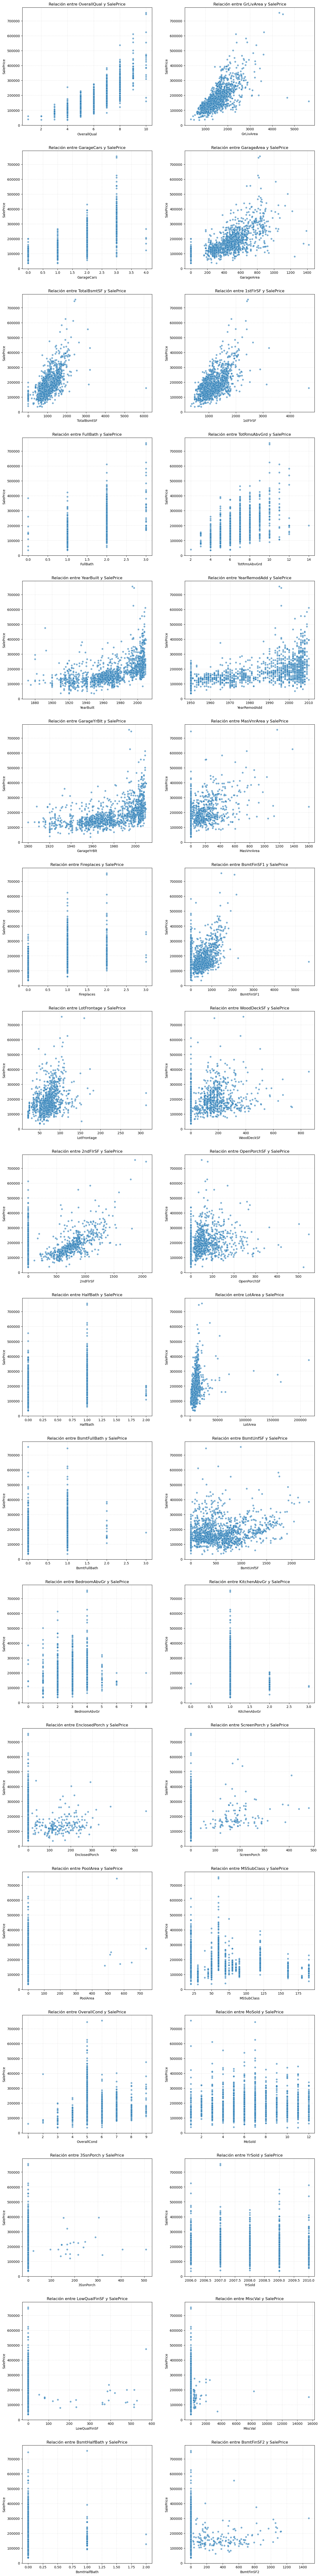

In [ ]:
graficar_relaciones(dataframe=df, 
                    features=ListaMax_corr, 
                    target_variable='SalePrice',
                    )

##### Variables no numericas

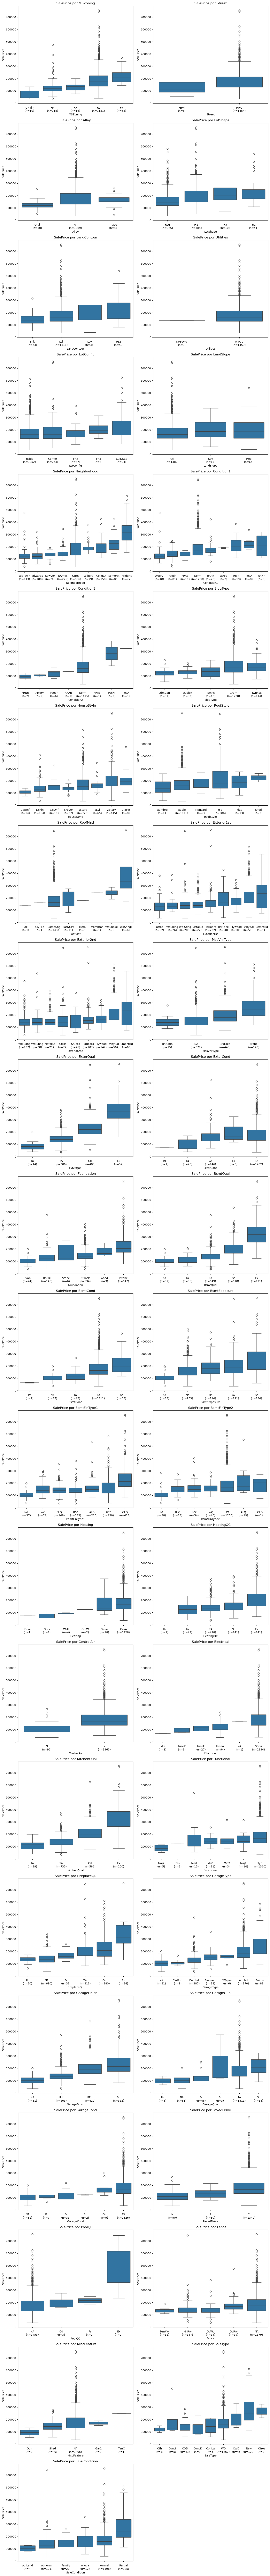

In [ ]:
boxplots_categoricas(dataframe=df,features=Categorias,target_variable='SalePrice')

#### Observaciones de variables numericas

vamos a revisar los outliers en el rango de los 700000

#### Observaciones de variabbles no numericas: